# Cosmo's Customer Purchase Behavior

### Datasets: https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

In [2]:
import matplotlib.dates as dates
from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
import math

%matplotlib inline
import numpy as np 
import pandas as pd 
import seaborn as sns

import scipy

import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import matplotlib as mpl
import seaborn as sns
import glob
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [190]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso

In [208]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [6]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "fulldata.csv", index=False, encoding='utf-8-sig')
print("Data is ready")

Data is ready


In [239]:
#Reading the data
df = pd.read_csv("fulldata.csv")

## 1. Cleaning the Datasets

In [210]:
#Check how many row and column
print(df.shape)
#Formalities see the topmost data
df.head()

(20692840, 9)


event_time event_type  product_id          category_id  \
0  2020-01-01 00:00:00 UTC       view     5809910  1602943681873052386   
1  2020-01-01 00:00:09 UTC       view     5812943  1487580012121948301   
2  2020-01-01 00:00:19 UTC       view     5798924  1783999068867920626   
3  2020-01-01 00:00:24 UTC       view     5793052  1487580005754995573   
4  2020-01-01 00:00:25 UTC       view     5899926  2115334439910245200   

  category_code     brand  price    user_id  \
0           NaN   grattol   5.24  595414620   
1           NaN  kinetics   3.97  595414640   
2           NaN    zinger   3.97  595412617   
3           NaN       NaN   4.92  420652863   
4           NaN       NaN   3.92  484071203   

                           user_session  
0  4adb70bb-edbd-4981-b60f-a05bfd32683a  
1  c8c5205d-be43-4f1d-aa56-4828b8151c8a  
2  46a5010f-bd69-4fbe-a00d-bb17aa7b46f3  
3  546f6af3-a517-4752-a98b-80c4c5860711  
4  cff70ddf-529e-4b0c-a4fc-f43a749c0acb

#There is 20692840 row of data and 9 columns

In [211]:
#checking the number of null values per each column
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    20339246
brand             8757117
price                   0
user_id                 0
user_session         4598
dtype: int64

In [212]:
# Create null cols and non-null columns
null_cols = df.columns[df.isnull().sum()>0]
# Non nulls are those with same lenght as df
not_null_cols = df.columns[df.notnull().sum()==20692840]
# Create null df and non-null df
null_df= df[null_cols]
not_null_df= df[not_null_cols]
df_null_sum = df.isnull().sum()
df_is_null = df.isnull()

Text(0.5, 1.0, 'Null values in the dataset')

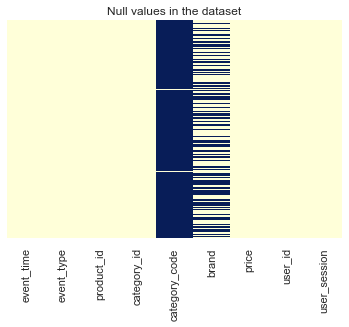

In [213]:
#visulaization of data set with null values
#Yellow Part: Null Variables
#There are more than 40% of missing values for category_code and brand but we will not remove them because there are no other variables that could explain the product characteristics.
#and this is variable is not our main concern.
#So we are dropping those columns.
sample_null_sort = df_is_null.sort_values('user_id')
sns.heatmap(sample_null_sort,cbar=False, cmap="YlGnBu", yticklabels=False,)
plt.title('Null values in the dataset')

In [214]:
#remove negative values for price
df = df[df['price']>= 0] 

<AxesSubplot:>

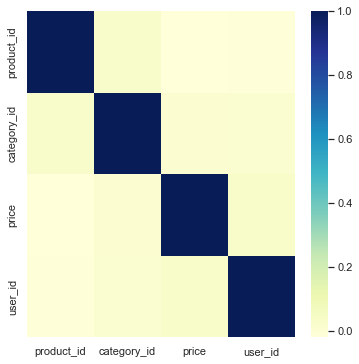

In [215]:
#correlations between columns
plt.figure(figsize=(6,6)) 

sns.heatmap(df.corr(), cmap="YlGnBu")

In [475]:
# since we had 20692840 oberservations we randomly picked 100000 from the data set for our model1.
import pandas
import random

n = 20692840 #number of records in file
s = 100000 #desired sample size
filename = "fulldata.csv"
skip = sorted(random.sample(range(1,n+1),n-s)) 
df = pandas.read_csv("fulldata.csv", skiprows=skip)


In [217]:
df.head()

event_time        event_type  product_id          category_id  \
0  2020-01-01 00:00:57 UTC              view     5726464  1487580005268456287   
1  2020-01-01 00:44:23 UTC              cart     5794155  1487580005671109489   
2  2020-01-01 00:46:14 UTC  remove_from_cart     5615144  1487580005092295511   
3  2020-01-01 01:39:57 UTC              cart     5869082  1602943681873052386   
4  2020-01-01 02:30:30 UTC              view     5809798  1487580012096782476   

  category_code    brand  price    user_id  \
0           NaN      NaN   5.56  420652863   
1           NaN   masura   1.73  595419945   
2           NaN      NaN   4.76  470057589   
3           NaN  grattol   4.76  595424692   
4           NaN     milv   1.27  595432549   

                           user_session  
0  546f6af3-a517-4752-a98b-80c4c5860711  
1  d462d23b-f6ec-483a-b3db-5461bb79471e  
2  3ed44c4b-a34f-40fe-8813-7dcad7578898  
3  8a6d29f1-78ab-49ec-83df-38a310ae29ee  
4  3afcf3f9-b13e-49b6-8874-c7dfd57439b7

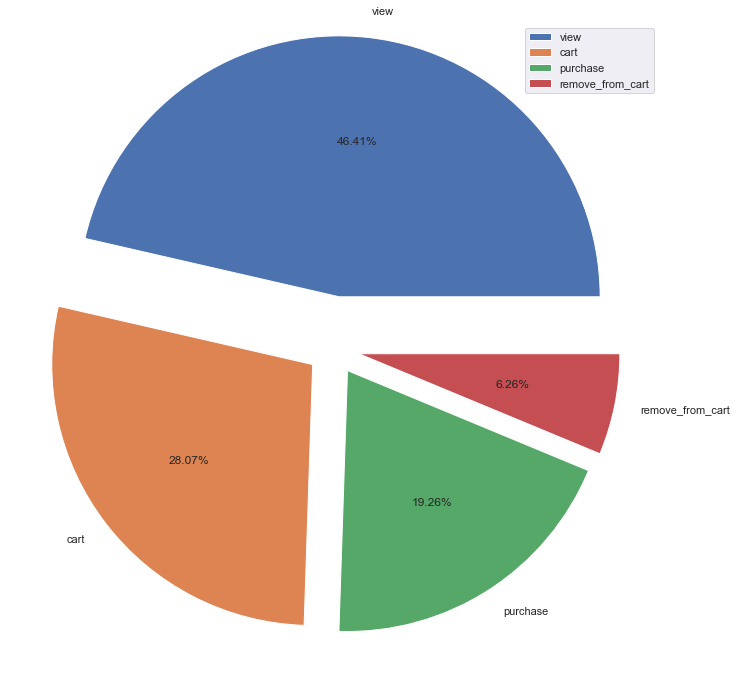

In [218]:
#percentage of each event_type
labels = ['view', 'cart','purchase','remove_from_cart']
size = df['event_type'].value_counts()
explode = [0.2, 0.1,0.1,0.1] 

plt.rcParams['figure.figsize'] = (13, 12)
plt.pie(size, explode = explode, labels = labels, shadow = False, autopct = '%.2f%%')
plt.axis('off')
plt.legend()
plt.show()

In [476]:
#Changing time variable to extract event actions per hour
yr=  df.event_time.str.slice(0,4)
mo = df.event_time.str.slice(5,7)
da = df.event_time.str.slice(8,10)
time = df.event_time.str.slice(10,-3).str.strip()
time_zone = df.event_time.str.slice(-3).str.strip()

In [477]:
hr = time.str.slice(0,2).str.strip()

min = time.str.slice(3,5).str.strip()

sec= time.str.slice(6).str.strip()

In [478]:
mo = mo.str.zfill(2)
da =da.str.zfill(2)
hr = hr.str.zfill(2)
min=min.str.zfill(2)
sec= sec.str.zfill(2)

In [479]:
date_df = pd.DataFrame({'yr':yr,'mo':mo,'da':da})
date = date_df.astype(str).apply("-".join,axis=1)

In [480]:
time_df = pd.DataFrame({'hr':hr,'min':min,'sec':sec})
time = time_df.astype(str).apply(":".join,axis=1)

In [481]:
df['Date'] = date 
df['time'] = time
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df['hr'] = pd.to_datetime(df['time'], format="%H:%M:%S").dt.hour
df.set_index('Date', inplace=True, drop=True)
df.drop(['event_time','time'], axis=1, inplace=True)

In [482]:
grp_by_hr_event_type = df.groupby(['hr','event_type']).count()

In [483]:
layout= dict(title="Hourly Store Traffic", xaxis_title="Time of Day", yaxis_title="Number of  Users")
a=grp_by_hr_event_type['user_id'].unstack()


In [201]:
a= pd.DataFrame(a)
a

event_type  cart  purchase  remove_from_cart  view
hr                                                
0            306        63               191   447
1            256        50               181   360
2            318        52               208   400
3            421        82               274   577
4            559       109               422   841
5            877       180               571  1277
6           1115       247               804  1799
7           1330       297               840  2172
8           1425       337              1004  2387
9           1513       358              1056  2573
10          1510       377              1120  2648
11          1629       406              1168  2802
12          1662       388              1137  2838
13          1528       370              1054  2569
14          1512       355              1020  2554
15          1392       302               973  2440
16          1476       338              1008  2532
17          1526       338              1105  2835
18          1762       339              1259  2873
19          1861       359              1324  3085
20          1678       326              1127  2819
21          1144       230               829  1923
22           706       132               455  1127
23           424        85               282   660

In [202]:
a['hr'] = range(0, 0+len(a))

Text(0, 0.5, 'Number of occured event type')

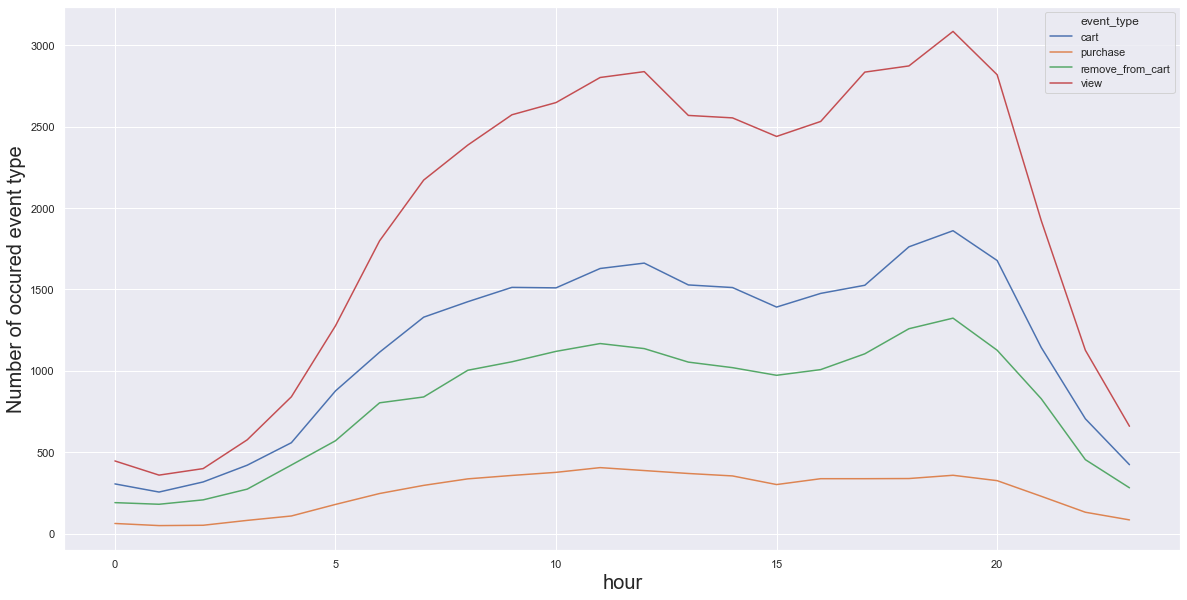

In [203]:
# visulization for the the number of actions per hr
a.set_index('hr').plot(figsize=(20,10));
plt.xlabel('hour', size=20)
plt.ylabel('Number of occured event type', size=20)

In [204]:
import pandasql as ps
from pandasql import sqldf

# Model1: Predicting Purchase likelihood using RandomForest & Logistic Regression

In [484]:
#Calculating avg number of actions per customer
mysql = lambda df: sqldf(df, globals())

In [485]:
query = "SELECT user_id, avg(num_actions) as avg_num_actions FROM (select user_id, product_id,COUNT(event_type) AS num_actions FROM df group by user_id, product_id) A group by user_id;"
mysql(query)

user_id  avg_num_actions
0        4661182              1.0
1       10079204              1.0
2       10280338              1.0
3       12961898              1.0
4       15391092              1.0
...          ...              ...
67644  622066161              1.0
67645  622067665              1.0
67646  622069802              1.0
67647  622081216              1.0
67648  622082947              1.0

[67649 rows x 2 columns]

In [486]:
query2= "SELECT user_id, 1-(SUM(case when event_type = 'purchase' then 1 else 0 end)/(SUM(case when event_type = 'cart' then 1 else 0 end)- SUM(case when event_type = 'remove_from_cart' then 1 else 0 end))) as abandrate FROM df group by user_id;"
mysql(query2)

user_id  abandrate
0        4661182        1.0
1       10079204        NaN
2       10280338        2.0
3       12961898        1.0
4       15391092        NaN
...          ...        ...
67644  622066161        NaN
67645  622067665        1.0
67646  622069802        1.0
67647  622081216        NaN
67648  622082947        NaN

[67649 rows x 2 columns]

In [487]:
query3= "SELECT user_id, case when event_type = 'purchase' then 1 else 0 end as purchase FROM df group by user_id;"
mysql(query3)


user_id  purchase
0        4661182         0
1       10079204         1
2       10280338         1
3       12961898         0
4       15391092         0
...          ...       ...
67644  622066161         1
67645  622067665         0
67646  622069802         0
67647  622081216         0
67648  622082947         0

[67649 rows x 2 columns]

In [488]:
df1= pd.DataFrame(mysql(query), columns=['user_id', 'avg_num_actions'])

<AxesSubplot:xlabel='user_id'>

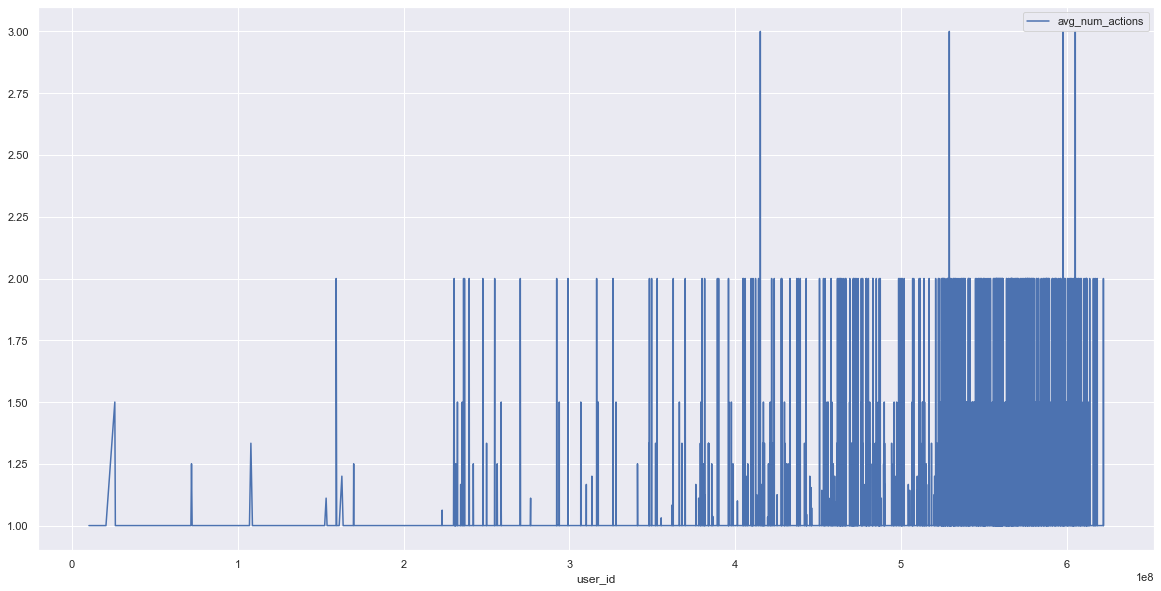

In [210]:
#plot of avg number of actions
df1.set_index('user_id').plot(figsize=(20,10))

In [489]:
df2= pd.DataFrame(mysql(query2), columns=['user_id', 'abandrate'])

<AxesSubplot:xlabel='user_id'>

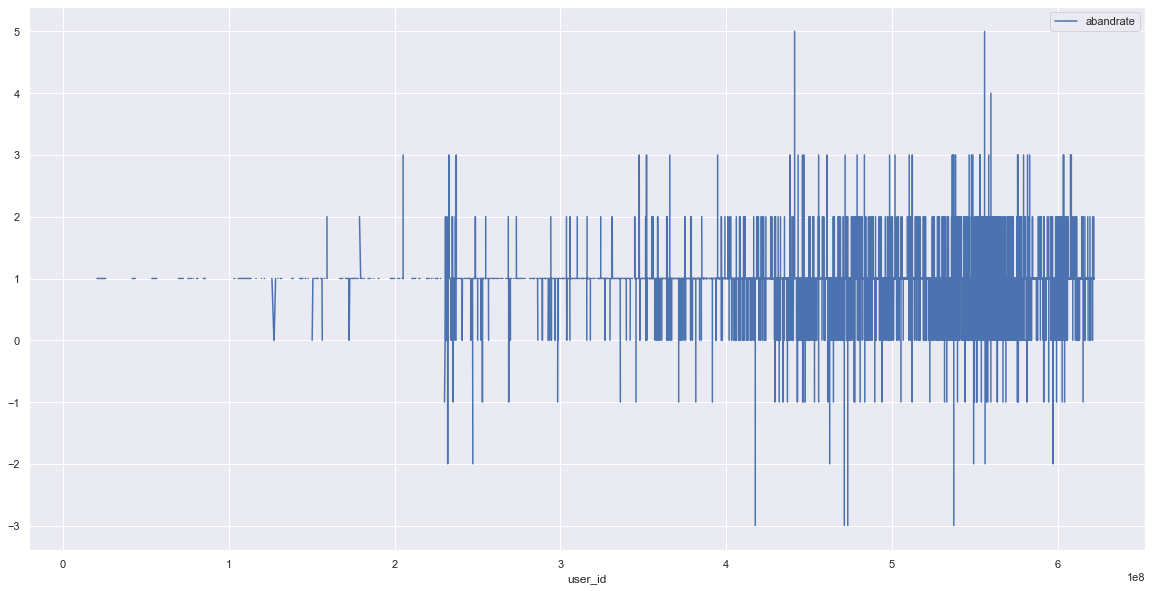

In [212]:
#plot of shopping cart abandonment rate
df2.set_index('user_id').plot(figsize=(20,10))

In [490]:
df3= pd.DataFrame(mysql(query3), columns=['user_id', 'product_id', 'purchase'])

In [491]:
df4=pd.merge(df,df1,on='user_id')
df5=pd.merge(df4,df2,on='user_id')

In [492]:
df6 = pd.merge(df5,df3, on='user_id')

In [493]:
df6d = pd.get_dummies(df6['event_type'])

In [494]:
df6d=pd.get_dummies(data=df6, columns=['event_type'])

In [217]:
df6d

product_id_x          category_id category_code     brand  price  \
0           5823778  1487580013749338323           NaN     estel   2.38   
1           5591314  1487580005268456287           NaN       NaN   4.29   
2           5746395  1487580005671109489           NaN    masura   3.95   
3           5796988  1487580005671109489           NaN    masura   1.67   
4           5726648  1487580008145748965           NaN       NaN   0.79   
...             ...                  ...           ...       ...    ...   
99995       5895622  1487580007256556476           NaN       NaN   6.43   
99996       5886282  1487580013950664926           NaN       NaN  21.59   
99997       5700068  1487580012902088873           NaN    runail  23.81   
99998       5830553  1487580005671109489           NaN    masura   1.73   
99999       5725633  1487580005713052531           NaN  ingarden   9.44   

         user_id                          user_session  hr  avg_num_actions  \
0      535821133  9eee3edb-9240-432a-bab6-fb5e2ac60ff7   0              1.0   
1      470057589  3ed44c4b-a34f-40fe-8813-7dcad7578898   0              1.0   
2      470057589  260dc7cd-30f9-4ebc-8256-1547f48aa504  13              1.0   
3      470057589  cff882d4-574e-4d82-a8e0-369233a05287  15              1.0   
4      336065468  8c3a4b60-b488-4848-9e9f-8c7ee751e0c0   0              1.0   
...          ...                                   ...  ..              ...   
99995  243830082  8ed39b0b-ac5c-401c-9d9a-c3a068364c9a  22              1.0   
99996  552070650  14b504b1-f3a1-4bc2-8d0b-835b47093cdd  22              1.0   
99997  412798527  80605fae-fd92-4c29-9a4a-df8138b24693  23              1.0   
99998  566245102  06c701d4-7935-4135-9b2c-3be770eb2fdb  23              1.0   
99999  566259681  dc575696-2574-4ef3-891f-c51651dd498b  23              1.0   

       abandrate  product_id_y  purchase  event_type_cart  \
0            NaN           NaN         0                0   
1            1.0           NaN         0                0   
2            1.0           NaN         0                0   
3            1.0           NaN         0                1   
4           -1.0           NaN         1                0   
...          ...           ...       ...              ...   
99995        NaN           NaN         0                0   
99996        NaN           NaN         0                0   
99997        NaN           NaN         0                0   
99998        NaN           NaN         0                0   
99999        NaN           NaN         0                0   

       event_type_purchase  event_type_remove_from_cart  event_type_view  
0                        0                            0                1  
1                        0                            1                0  
2                        0                            1                0  
3                        0                            0                0  
4                        1                            0                0  
...                    ...                          ...              ...  
99995                    0                            0                1  
99996                    0                            0                1  
99997                    0                            0                1  
99998                    0                            0                1  
99999                    0                            0                1  

[100000 rows x 16 columns]

In [495]:
df7=df6d.drop(['product_id_x', 'category_id', 'user_id','user_session', 'category_code', 'brand', 'product_id_y'], axis=1)

In [229]:
df7.head()

price  hr  avg_num_actions  abandrate  purchase  event_type_cart  \
0   2.38   0              1.0        NaN         0                0   
1   4.29   0              1.0        1.0         0                0   
2   3.95  13              1.0        1.0         0                0   
3   1.67  15              1.0        1.0         0                1   
4   0.79   0              1.0       -1.0         1                0   

   event_type_purchase  event_type_remove_from_cart  event_type_view  
0                    0                            0                1  
1                    0                            1                0  
2                    0                            1                0  
3                    0                            0                0  
4                    1                            0                0

In [496]:
df7[:] = np.nan_to_num(df7)

In [497]:
numerical_columns = [col for col in df7.columns if (df7[col].dtype=='int64' or df7[col].dtype=='float64') and col != 'Exited']

In [222]:
#descriptive stats for numerical col
df7[numerical_columns].describe().loc[['min','max', 'mean','50%'],:]

price        hr  avg_num_actions  abandrate  purchase
min   -15.870000   0.00000         1.000000  -5.000000     0.000
max   327.780000  23.00000         3.000000   4.000000     1.000
mean    8.543284  13.08075         1.012242   0.977586     0.051
50%     4.030000  13.00000         1.000000   1.000000     0.000

In [498]:
#Our dataset for the modeling
X =  df7.drop(['purchase', 'event_type_purchase', 'event_type_cart','event_type_remove_from_cart', 'event_type_view' ], axis=1)
y = df7['purchase']

In [499]:
#Spliting test & training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [473]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [505]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [525]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

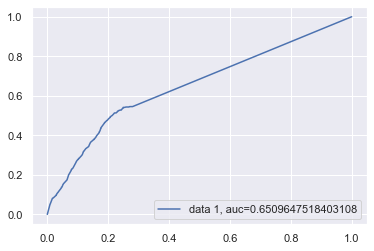

In [513]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [233]:
#Running Random Forest
from sklearn.ensemble import RandomForestClassifier
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.fit_transform(X_test)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train)
y_pred_rfc = random_forest_classifier.predict(X_test)
print(cm_random_forest_classifier,end="\n\n")

numerator = cm_random_forest_classifier[0][0] + cm_random_forest_classifier[1][1]
denominator = sum(cm_random_forest_classifier[0]) + sum(cm_random_forest_classifier[1])


    
    
spec_rfc= (cm_random_forest_classifier[0][0]/(cm_random_forest_classifier[0][0]+cm_random_forest_classifier[0][1]) ) *100
Sensi_rfc=(cm_random_forest_classifier[1][1]/(cm_random_forest_classifier[1][0]+cm_random_forest_classifier[1][1]))*100
acc_rfc = (numerator/denominator) * 100
print("Accuracy: ",round(acc_rfc,2),"%")
print("Sensitivity : ",round(Sensi_rfc,2),"%")
print("Specifity : ",round(spec_rfc,2),"%")

cross_val_rfc = cross_val_score(estimator=RandomForestClassifier(), X=X_train, y=y_train, cv=10, n_jobs=-1)
print("Cross Validation Accuracy : ",round(cross_val_rfc.mean() * 100 , 2),"%")

[[18579   417]
 [  935    69]]

Accuracy:  93.24 %
Sensitivity :  6.87 %
Specifity :  97.8 %
Cross Validation Accuracy :  94.11 %


In [166]:
con_mat_02 = metrics.confusion_matrix(y_test, y_pred_rfc)

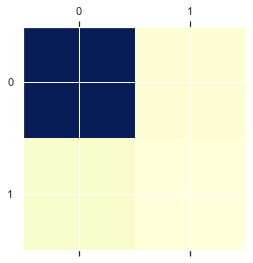

In [167]:
#Confusion Matrix
plt.matshow(con_mat_02, cmap="YlGnBu")
plt.show()

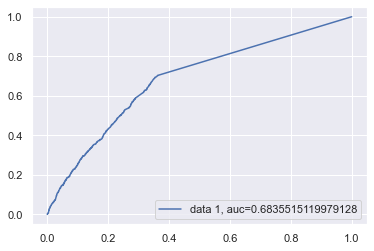

In [234]:
#ROC curve
y_pred_proba = random_forest_classifier .predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

<AxesSubplot:>

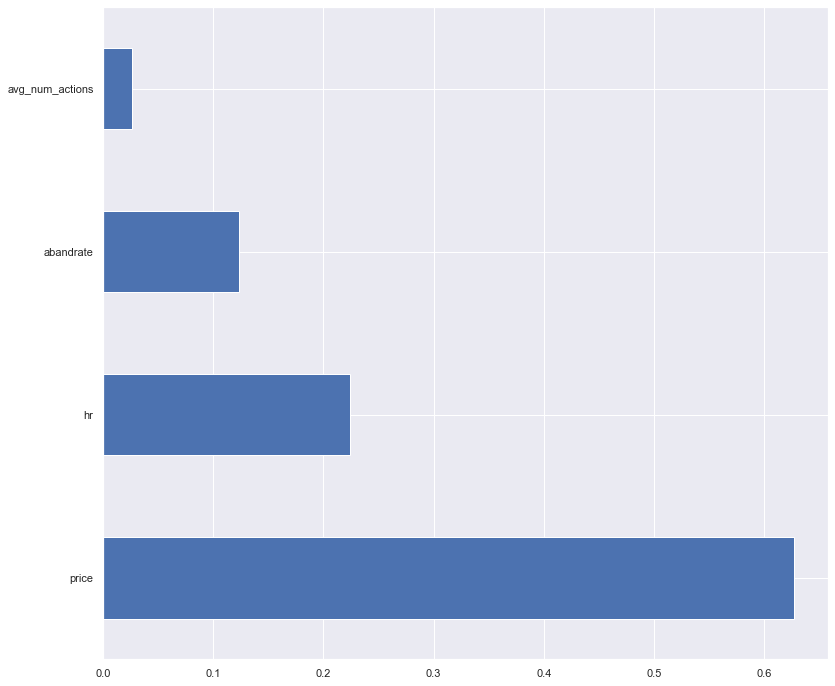

In [288]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')


In [114]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test,predictions ))  
print(accuracy_score(y_test, predictions ))



              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     18996
         1.0       0.18      0.04      0.07      1004

    accuracy                           0.94     20000
   macro avg       0.57      0.52      0.52     20000
weighted avg       0.91      0.94      0.92     20000

0.94265


In [235]:
#Running Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [189]:
print("Accuracy", metrics.accuracy_score(y_test, y_pred))


Accuracy 0.9499


In [187]:
con_mat_02 = metrics.confusion_matrix(y_test, y_pred)

In [188]:
print(con_mat_02)

[[18992     4]
 [  998     6]]


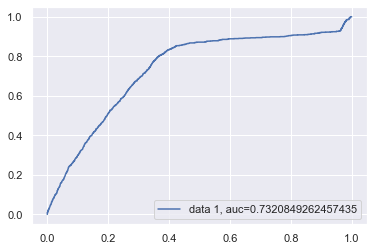

In [236]:
# ROC curve for Logistic Regression
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [237]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#for chapter 3.2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt


#for chapter 4
import statsmodels.api as sm

# Model2: Predicting the Next Purchase Date using Different Models

In [364]:
# We want to segment customer group with purchase activities
# So we are only using the data of customer with at least 1 purchase transaction
# We are re-reading the full dataset again
df = pd.read_csv("fulldata.csv")

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

df_sales=df_sales.drop(columns=['category_id'])

# step 3: drop duplicates
df_sales=df_sales.drop_duplicates()

# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)
df_sales['month'] = pd.DatetimeIndex(df_sales['event_time']).month
df_sales['month'] =pd.to_numeric(df_sales['month'], errors='coerce')

print(df_sales.shape)
df_sales.head()

(1286102, 9)


event_time event_type  product_id category_code brand  \
60  2020-01-01 00:06:07+00:00   purchase     5802440           NaN   NaN   
61  2020-01-01 00:06:07+00:00   purchase     5825203           NaN  kiss   
590 2020-01-01 00:51:38+00:00   purchase     5842655           NaN   NaN   
591 2020-01-01 00:52:00+00:00   purchase        4185           NaN   cnd   
593 2020-01-01 00:52:11+00:00   purchase     5700088           NaN   NaN   

     price    user_id                          user_session  month  
60    2.16  595411904  74ca1cd5-5381-4ffe-b00b-a258b390db77      1  
61    7.92  595411904  74ca1cd5-5381-4ffe-b00b-a258b390db77      1  
590  14.51  595351517  4ceb1e27-416e-4a3c-972a-03eb373d67b2      1  
591  19.37  287758725  b276b96f-724f-4081-b56b-e8bc5e32e0c8      1  
593  10.95  504269664  32a5c608-4d22-475b-87d6-abb058930dbf      1

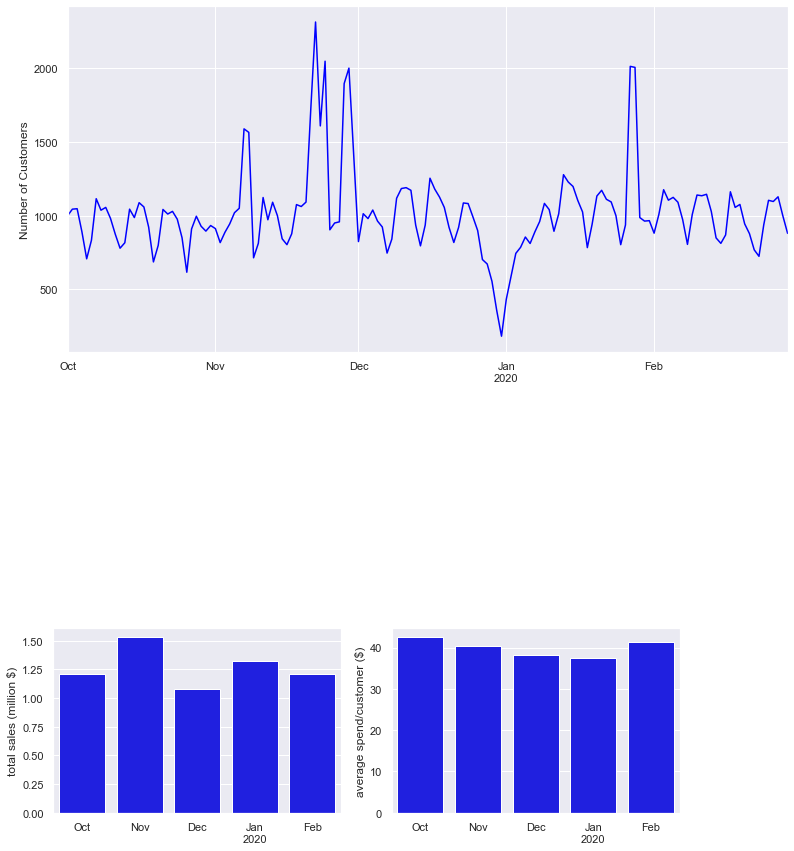

In [160]:
plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.1, 0.8, 1, 0.6])
df_p_n_user=df_p.resample("D",on='event_time')['user_id'].nunique()
df_p_n_user.plot(kind='line', color='blue')
plt.xlabel('')
plt.ylabel('Number of Customers')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_p.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="blue")
plt.xlabel('')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_p_p_day=df_p.resample('D',on='event_time')['price'].sum()
df_p_spent=df_p_p_day/df_p_n_user
sns.barplot(x='month',y=df_p_p_day/df_p_n_user,data=a,color="blue")
plt.xlabel('')
plt.ylabel('average spend/customer ($)');


# Model2-1. Begin New Cluster Analysis: RMF

We use 3 months of behavioral data to predict customers’ first purchase date in the next 2 months. If there is no purchase, we will predict that too. Lets use Oct to Dec data for train and we split the data as ...tx_6m represents the 3 months performance whereas we will use tx_next for the find out the days between the last purchase date in tx_6m and the first one in tx_next.

In [365]:
#customer w/ purchase in Oct-Dec
a=[1,2]
tx_6m=df_sales.loc[~df_sales.month.isin(a),:].copy()

In [366]:
#we will create a dataframe called tx_user to possess a user-level feature set for the prediction model

tx_user = pd.DataFrame(tx_6m['user_id'].unique())
tx_user.columns = ['user_id']

In [367]:
#customer w/ purchase in Jan-Fev
tx_next=df_sales.loc[df_sales.month.isin(a),:].copy()

In [368]:
#By using the data in tx_next, we need the calculate our label
#(days between last purchase before cut off date and first purchase after that):

tx_next_first_purchase = tx_next.groupby('user_id').event_time.min().reset_index()
tx_next_first_purchase.columns = ['user_id','MinPurchaseDate']
tx_next_first_purchase

user_id           MinPurchaseDate
0       10280338 2020-01-12 22:54:37+00:00
1       12936739 2020-01-17 07:51:19+00:00
2       20554973 2020-01-15 16:12:29+00:00
3       23633626 2020-01-28 09:09:10+00:00
4       25300038 2020-02-26 12:33:00+00:00
...          ...                       ...
49468  622065819 2020-02-29 22:29:19+00:00
49469  622066161 2020-02-29 21:54:22+00:00
49470  622067983 2020-02-29 22:33:37+00:00
49471  622069477 2020-02-29 22:05:30+00:00
49472  622073202 2020-02-29 22:14:08+00:00

[49473 rows x 2 columns]

In [251]:
#By using the data in tx_next, we need the calculate our label
#(days between last purchase before cut off date and first purchase after that):

tx_next_first_purchase = tx_next.groupby('user_id').event_time.min().reset_index()
tx_next_first_purchase.columns = ['user_id','MinPurchaseDate']
tx_next_first_purchase

user_id           MinPurchaseDate
0       10280338 2020-01-12 22:54:37+00:00
1       12936739 2020-01-17 07:51:19+00:00
2       20554973 2020-01-15 16:12:29+00:00
3       23633626 2020-01-28 09:09:10+00:00
4       25300038 2020-02-26 12:33:00+00:00
...          ...                       ...
49468  622065819 2020-02-29 22:29:19+00:00
49469  622066161 2020-02-29 21:54:22+00:00
49470  622067983 2020-02-29 22:33:37+00:00
49471  622069477 2020-02-29 22:05:30+00:00
49472  622073202 2020-02-29 22:14:08+00:00

[49473 rows x 2 columns]

In [369]:
tx_last_purchase = tx_6m.groupby('user_id').event_time.max().reset_index()
tx_last_purchase.columns = ['user_id','MaxPurchaseDate']
tx_last_purchase


user_id           MaxPurchaseDate
0        9794320 2019-11-25 05:07:13+00:00
1       10079204 2019-11-06 10:43:30+00:00
2       10280338 2019-11-21 11:31:09+00:00
3       12055855 2019-12-20 12:05:29+00:00
4       15400971 2019-12-13 13:12:22+00:00
...          ...                       ...
72220  595367593 2019-12-31 19:28:29+00:00
72221  595372293 2019-12-31 19:56:10+00:00
72222  595373694 2019-12-31 19:47:49+00:00
72223  595376179 2019-12-31 22:38:55+00:00
72224  595413503 2019-12-31 23:55:23+00:00

[72225 rows x 2 columns]

In [370]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='user_id',how='left')
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days
tx_purchase_dates.head()

user_id           MaxPurchaseDate           MinPurchaseDate  \
0   9794320 2019-11-25 05:07:13+00:00                       NaT   
1  10079204 2019-11-06 10:43:30+00:00                       NaT   
2  10280338 2019-11-21 11:31:09+00:00 2020-01-12 22:54:37+00:00   
3  12055855 2019-12-20 12:05:29+00:00                       NaT   
4  15400971 2019-12-13 13:12:22+00:00                       NaT   

   NextPurchaseDay  
0              NaN  
1              NaN  
2             52.0  
3              NaN  
4              NaN

In [371]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['user_id','NextPurchaseDay']],on='user_id',how='left')

tx_user.head()

user_id  NextPurchaseDay
0  473613801              NaN
1  547853931              NaN
2  433063720             41.0
3  494077766              NaN
4  579950721              NaN

In [372]:
tx_user.shape

(72225, 2)

In [373]:
#As you can easily notice, we have NaN values because those customers haven’t made any purchase yet.
#We fill NaN with 999 to quickly identify them later.
tx_user = tx_user.fillna(999)

##We have customer ids and corresponding labels in a dataframe. 
##Let’s enrich it with our feature set to build our machine learning model.

# A. Calculating Recency

In [374]:
####### tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase = tx_6m.groupby('user_id').event_time.max().reset_index()

tx_max_purchase.columns = ['user_id','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['user_id','Recency']], on='user_id')
tx_user.head()

user_id  NextPurchaseDay  Recency
0  473613801            999.0       30
1  547853931            999.0        6
2  433063720             41.0       30
3  494077766            999.0       30
4  579950721            999.0       30

In [375]:
#plot recency
plot_data = [go.Histogram(x=tx_user['Recency'])]

plot_layout = go.Layout(title='Recency')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

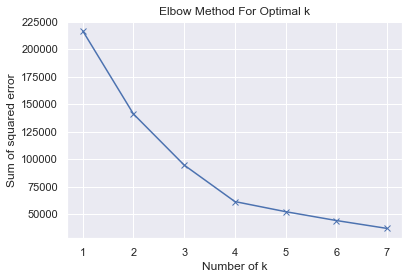

In [376]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data

X = StandardScaler().fit_transform(tx_user)

# step 2: find the optimal number of clusters
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km =km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of k')
plt.ylabel('Sum of squared error')
plt.title('Elbow Method For Optimal k')
plt.show()

In [377]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [378]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user.groupby('RecencyCluster')['Recency'].describe()

count       mean       std   min   25%   50%   75%   max
RecencyCluster                                                            
0               15253.0  79.482987  6.977328  68.0  74.0  79.0  85.0  91.0
1               15025.0  55.914143  6.139591  46.0  51.0  55.0  61.0  67.0
2               21778.0  34.679952  5.714011  24.0  31.0  35.0  39.0  45.0
3               20169.0  12.577520  6.314917   0.0   7.0  13.0  18.0  23.0

# B. Calculating Frequency

In [379]:
#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('user_id').event_time.count().reset_index()
tx_frequency.columns = ['user_id','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='user_id')

In [380]:
#plot frequency
plot_data = [ go.Histogram(x=tx_user.query('Frequency < 1000')['Frequency'])]

plot_layout = go.Layout(title='Frequency')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [394]:
#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


count        mean        std   min    25%    50%    75%  \
FrequencyCluster                                                              
0                 53898.0    4.945657   3.158778   1.0    2.0    4.0    7.0   
1                 14732.0   20.209340   6.225550  13.0   15.0   19.0   24.0   
2                  3247.0   52.653218  13.622174  37.0   41.0   49.0   60.0   
3                   348.0  130.362069  46.860833  92.0  100.0  116.5  139.0   

                    max  
FrequencyCluster         
0                  12.0  
1                  36.0  
2                  91.0  
3                 438.0

# C. Calculating Monetary Value

In [381]:
#tx_6m['Revenue']=tx_6m.groupby('user_id').price.sum()
tx_6m['Revenue']=pd.to_numeric(tx_6m.price).groupby(tx_6m.user_id).sum()
tx_6m
print(tx_6m)

                        event_time event_type  product_id category_code  \
4265309  2019-12-01 00:17:50+00:00   purchase        4554           NaN   
4265310  2019-12-01 00:17:50+00:00   purchase        4600           NaN   
4265311  2019-12-01 00:17:50+00:00   purchase        4607           NaN   
4265312  2019-12-01 00:17:50+00:00   purchase        4640           NaN   
4265313  2019-12-01 00:17:50+00:00   purchase        4689           NaN   
...                            ...        ...         ...           ...   
20692769 2019-10-31 23:55:35+00:00   purchase     5692914           NaN   
20692770 2019-10-31 23:55:35+00:00   purchase     5836522           NaN   
20692771 2019-10-31 23:55:35+00:00   purchase     5824227           NaN   
20692772 2019-10-31 23:55:35+00:00   purchase     5793704           NaN   
20692773 2019-10-31 23:55:35+00:00   purchase     5788441           NaN   

             brand  price    user_id                          user_session  \
4265309     runail   

In [382]:
tx_6m_rev=tx_6m.groupby('user_id')['price'].sum().reset_index()
tx_6m_rev.columns = ['user_id','Revenue']
print(tx_6m_rev)
#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_6m_rev, on='user_id')
print(tx_user)
#dftest=tx_6m.loc[tx_6m.user_id==579859772,].copy()
#dftest

         user_id  Revenue
0        9794320    12.68
1       10079204    25.81
2       10280338    54.83
3       12055855    16.54
4       15400971    35.71
...          ...      ...
72220  595367593    30.39
72221  595372293    42.54
72222  595373694    19.83
72223  595376179    46.49
72224  595413503    10.95

[72225 rows x 2 columns]
         user_id  NextPurchaseDay  Recency  RecencyCluster  Frequency  Revenue
0      473613801            999.0       30               2         30    33.31
1      433063720             41.0       30               2         31   180.74
2      494077766            999.0       30               2         50   215.93
3      579950721            999.0       30               2          8    65.89
4      361564578            999.0       30               2         44   143.01
...          ...              ...      ...             ...        ...      ...
72220  299380685            999.0       68               0         25    94.43
72221  417621990            99

In [383]:
tx_user.Revenue

0         33.31
1        180.74
2        215.93
3         65.89
4        143.01
          ...  
72220     94.43
72221     52.22
72222     51.26
72223     10.16
72224     44.22
Name: Revenue, Length: 72225, dtype: float64

In [384]:
tx_user.Revenue.describe()

count    72225.000000
mean        52.861117
std         72.625986
min         -7.200000
25%         16.200000
50%         32.610000
75%         58.750000
max       2715.870000
Name: Revenue, dtype: float64

In [391]:
plot_data = [go.Histogram( x=tx_user.query('Revenue < 10000')['Revenue'])]

plot_layout = go.Layout(title='Monetary Value')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [392]:
#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


count        mean         std     min       25%      50%  \
RevenueCluster                                                               
0               56118.0   27.474785   15.740215   -7.20   13.9700   23.850   
1               12930.0  101.800546   30.307047   64.52   76.9700   93.525   
2                2875.0  261.183843   70.689515  181.20  205.7250  238.020   
3                 302.0  691.654404  292.031401  478.06  528.3875  593.965   

                     75%      max  
RevenueCluster                     
0                40.0375    64.51  
1               121.3800   181.15  
2               300.5500   475.21  
3               743.3500  2715.87

In [396]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['user_id','event_time']]
#convert Invoice Datetime to day
tx_day_order['eventDay'] = tx_6m['event_time'].dt.date
tx_day_order = tx_day_order.sort_values(['user_id','event_time'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['user_id','eventDay'],keep='first')
tx_day_order

user_id                event_time    eventDay
15583557    9794320 2019-11-25 05:07:13+00:00  2019-11-25
12652763   10079204 2019-11-06 10:43:30+00:00  2019-11-06
14641867   10280338 2019-11-20 18:36:14+00:00  2019-11-20
14766393   10280338 2019-11-21 11:31:09+00:00  2019-11-21
6782287    12055855 2019-12-20 12:05:29+00:00  2019-12-20
...             ...                       ...         ...
7794158   595367593 2019-12-31 19:28:29+00:00  2019-12-31
7794704   595372293 2019-12-31 19:56:10+00:00  2019-12-31
7794579   595373694 2019-12-31 19:47:49+00:00  2019-12-31
7797120   595376179 2019-12-31 22:38:55+00:00  2019-12-31
7797985   595413503 2019-12-31 23:55:23+00:00  2019-12-31

[93568 rows x 3 columns]

In [397]:
#########lag data
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('user_id')['eventDay'].shift(1) #most latest
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('user_id')['eventDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('user_id')['eventDay'].shift(3)
tx_day_order

user_id                event_time    eventDay PrevInvoiceDate  \
15583557    9794320 2019-11-25 05:07:13+00:00  2019-11-25             NaN   
12652763   10079204 2019-11-06 10:43:30+00:00  2019-11-06             NaN   
14641867   10280338 2019-11-20 18:36:14+00:00  2019-11-20             NaN   
14766393   10280338 2019-11-21 11:31:09+00:00  2019-11-21      2019-11-20   
6782287    12055855 2019-12-20 12:05:29+00:00  2019-12-20             NaN   
...             ...                       ...         ...             ...   
7794158   595367593 2019-12-31 19:28:29+00:00  2019-12-31             NaN   
7794704   595372293 2019-12-31 19:56:10+00:00  2019-12-31             NaN   
7794579   595373694 2019-12-31 19:47:49+00:00  2019-12-31             NaN   
7797120   595376179 2019-12-31 22:38:55+00:00  2019-12-31             NaN   
7797985   595413503 2019-12-31 23:55:23+00:00  2019-12-31             NaN   

         T2InvoiceDate T3InvoiceDate  
15583557           NaN           NaN  
12652763           NaN           NaN  
14641867           NaN           NaN  
14766393           NaN           NaN  
6782287            NaN           NaN  
...                ...           ...  
7794158            NaN           NaN  
7794704            NaN           NaN  
7794579            NaN           NaN  
7797120            NaN           NaN  
7797985            NaN           NaN  

[93568 rows x 6 columns]

In [398]:
tx_day_order['DayDiff'] = (tx_day_order['eventDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['eventDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['eventDay'] - tx_day_order['T3InvoiceDate']).dt.days
tx_day_order

user_id                event_time    eventDay PrevInvoiceDate  \
15583557    9794320 2019-11-25 05:07:13+00:00  2019-11-25             NaN   
12652763   10079204 2019-11-06 10:43:30+00:00  2019-11-06             NaN   
14641867   10280338 2019-11-20 18:36:14+00:00  2019-11-20             NaN   
14766393   10280338 2019-11-21 11:31:09+00:00  2019-11-21      2019-11-20   
6782287    12055855 2019-12-20 12:05:29+00:00  2019-12-20             NaN   
...             ...                       ...         ...             ...   
7794158   595367593 2019-12-31 19:28:29+00:00  2019-12-31             NaN   
7794704   595372293 2019-12-31 19:56:10+00:00  2019-12-31             NaN   
7794579   595373694 2019-12-31 19:47:49+00:00  2019-12-31             NaN   
7797120   595376179 2019-12-31 22:38:55+00:00  2019-12-31             NaN   
7797985   595413503 2019-12-31 23:55:23+00:00  2019-12-31             NaN   

         T2InvoiceDate T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
15583557           NaN           NaN      NaN       NaN       NaN  
12652763           NaN           NaN      NaN       NaN       NaN  
14641867           NaN           NaN      NaN       NaN       NaN  
14766393           NaN           NaN      1.0       NaN       NaN  
6782287            NaN           NaN      NaN       NaN       NaN  
...                ...           ...      ...       ...       ...  
7794158            NaN           NaN      NaN       NaN       NaN  
7794704            NaN           NaN      NaN       NaN       NaN  
7794579            NaN           NaN      NaN       NaN       NaN  
7797120            NaN           NaN      NaN       NaN       NaN  
7797985            NaN           NaN      NaN       NaN       NaN  

[93568 rows x 9 columns]

In [399]:
#For each customer ID, we utilize .agg() method to 
#find out the mean and standard deviation of the difference between purchases in days
tx_day_diff = tx_day_order.groupby('user_id').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['user_id', 'DayDiffMean','DayDiffStd']
tx_day_diff

user_id  DayDiffMean  DayDiffStd
0        9794320          NaN         NaN
1       10079204          NaN         NaN
2       10280338          1.0         NaN
3       12055855          NaN         NaN
4       15400971          NaN         NaN
...          ...          ...         ...
72220  595367593          NaN         NaN
72221  595372293          NaN         NaN
72222  595373694          NaN         NaN
72223  595376179          NaN         NaN
72224  595413503          NaN         NaN

[72225 rows x 3 columns]

In [400]:
#We only keep customers who have > 3 purchases by using the following line

tx_day_order_last = tx_day_order.drop_duplicates(subset=['user_id'],keep='last')

In [401]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='user_id')
tx_user = pd.merge(tx_user, tx_day_order_last[['user_id','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='user_id')

tx_user

user_id  NextPurchaseDay  Recency  RecencyCluster  Frequency  Revenue  \
0     521821140             66.0       30               2         20    53.15   
1     508843109             50.0       30               2         23    62.93   
2     549634945            999.0       29               2         15    58.26   
3     258836295            999.0       24               2         19    60.67   
4     555434565            999.0       38               2         18    59.10   
...         ...              ...      ...             ...        ...      ...   
1794  540150011             27.0        3               3        110  1236.11   
1795  549195612            999.0       60               1        159   981.97   
1796  556450099            999.0       46               1        104   927.01   
1797  500124637            999.0       48               1        125   497.30   
1798  255405324            999.0       50               1        111   525.34   

      RevenueCluster  FrequencyCluster  OverallScore     Segment  DayDiff  \
0                  0                 1             3   Mid-Value     28.0   
1                  0                 1             3   Mid-Value      1.0   
2                  0                 1             3   Mid-Value     25.0   
3                  0                 1             3   Mid-Value     10.0   
4                  0                 1             3   Mid-Value     19.0   
...              ...               ...           ...         ...      ...   
1794               3                 3             9  High-Value     29.0   
1795               3                 3             7  High-Value      7.0   
1796               3                 3             7  High-Value      3.0   
1797               3                 3             7  High-Value      2.0   
1798               3                 3             7  High-Value     14.0   

      DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0         33.0      46.0    15.333333   11.676187  
1         29.0      51.0    17.000000   14.177447  
2         33.0      56.0    18.666667    9.291573  
3         11.0      15.0     4.250000    4.031129  
4         20.0      21.0     7.000000   10.392305  
...        ...       ...          ...         ...  
1794      56.0      63.0    21.750000   10.045729  
1795       8.0      11.0     4.333333    3.881580  
1796       4.0       7.0     2.800000    1.820518  
1797       6.0      25.0    10.250000    8.500000  
1798      23.0      41.0    13.666667    4.509250  

[1799 rows x 15 columns]

In [402]:
#create tx_class as a copy of tx_user before applying get_dummies

tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)
tx_class

user_id  NextPurchaseDay  Recency  RecencyCluster  Frequency  Revenue  \
0     521821140             66.0       30               2         20    53.15   
1     508843109             50.0       30               2         23    62.93   
2     549634945            999.0       29               2         15    58.26   
3     258836295            999.0       24               2         19    60.67   
4     555434565            999.0       38               2         18    59.10   
...         ...              ...      ...             ...        ...      ...   
1794  540150011             27.0        3               3        110  1236.11   
1795  549195612            999.0       60               1        159   981.97   
1796  556450099            999.0       46               1        104   927.01   
1797  500124637            999.0       48               1        125   497.30   
1798  255405324            999.0       50               1        111   525.34   

      RevenueCluster  FrequencyCluster  OverallScore  DayDiff  DayDiff2  \
0                  0                 1             3     28.0      33.0   
1                  0                 1             3      1.0      29.0   
2                  0                 1             3     25.0      33.0   
3                  0                 1             3     10.0      11.0   
4                  0                 1             3     19.0      20.0   
...              ...               ...           ...      ...       ...   
1794               3                 3             9     29.0      56.0   
1795               3                 3             7      7.0       8.0   
1796               3                 3             7      3.0       4.0   
1797               3                 3             7      2.0       6.0   
1798               3                 3             7     14.0      23.0   

      DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
0         46.0    15.333333   11.676187                   0   
1         51.0    17.000000   14.177447                   0   
2         56.0    18.666667    9.291573                   0   
3         15.0     4.250000    4.031129                   0   
4         21.0     7.000000   10.392305                   0   
...        ...          ...         ...                 ...   
1794      63.0    21.750000   10.045729                   1   
1795      11.0     4.333333    3.881580                   1   
1796       7.0     2.800000    1.820518                   1   
1797      25.0    10.250000    8.500000                   1   
1798      41.0    13.666667    4.509250                   1   

      Segment_Low-Value  Segment_Mid-Value  
0                     0                  1  
1                     0                  1  
2                     0                  1  
3                     0                  1  
4                     0                  1  
...                 ...                ...  
1794                  0                  0  
1795                  0                  0  
1796                  0                  0  
1797                  0                  0  
1798                  0                  0  

[1799 rows x 17 columns]

In [403]:
#Before jumping into choosing the model, we need to take two actions. 
#First, we need to identify the classes in our label. Generally, percentiles give the right for that

tx_user.NextPurchaseDay.describe()

count    1799.000000
mean      335.909950
std       447.885816
min         2.000000
25%        25.000000
50%        42.000000
75%       999.000000
max       999.000000
Name: NextPurchaseDay, dtype: float64

In [404]:

tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>40,'NextPurchaseDayRange'] = 0

In [405]:
tx_class.NextPurchaseDayRange.value_counts()/len(tx_user)

0    0.518621
1    0.315731
2    0.165648
Name: NextPurchaseDayRange, dtype: float64

<AxesSubplot:>

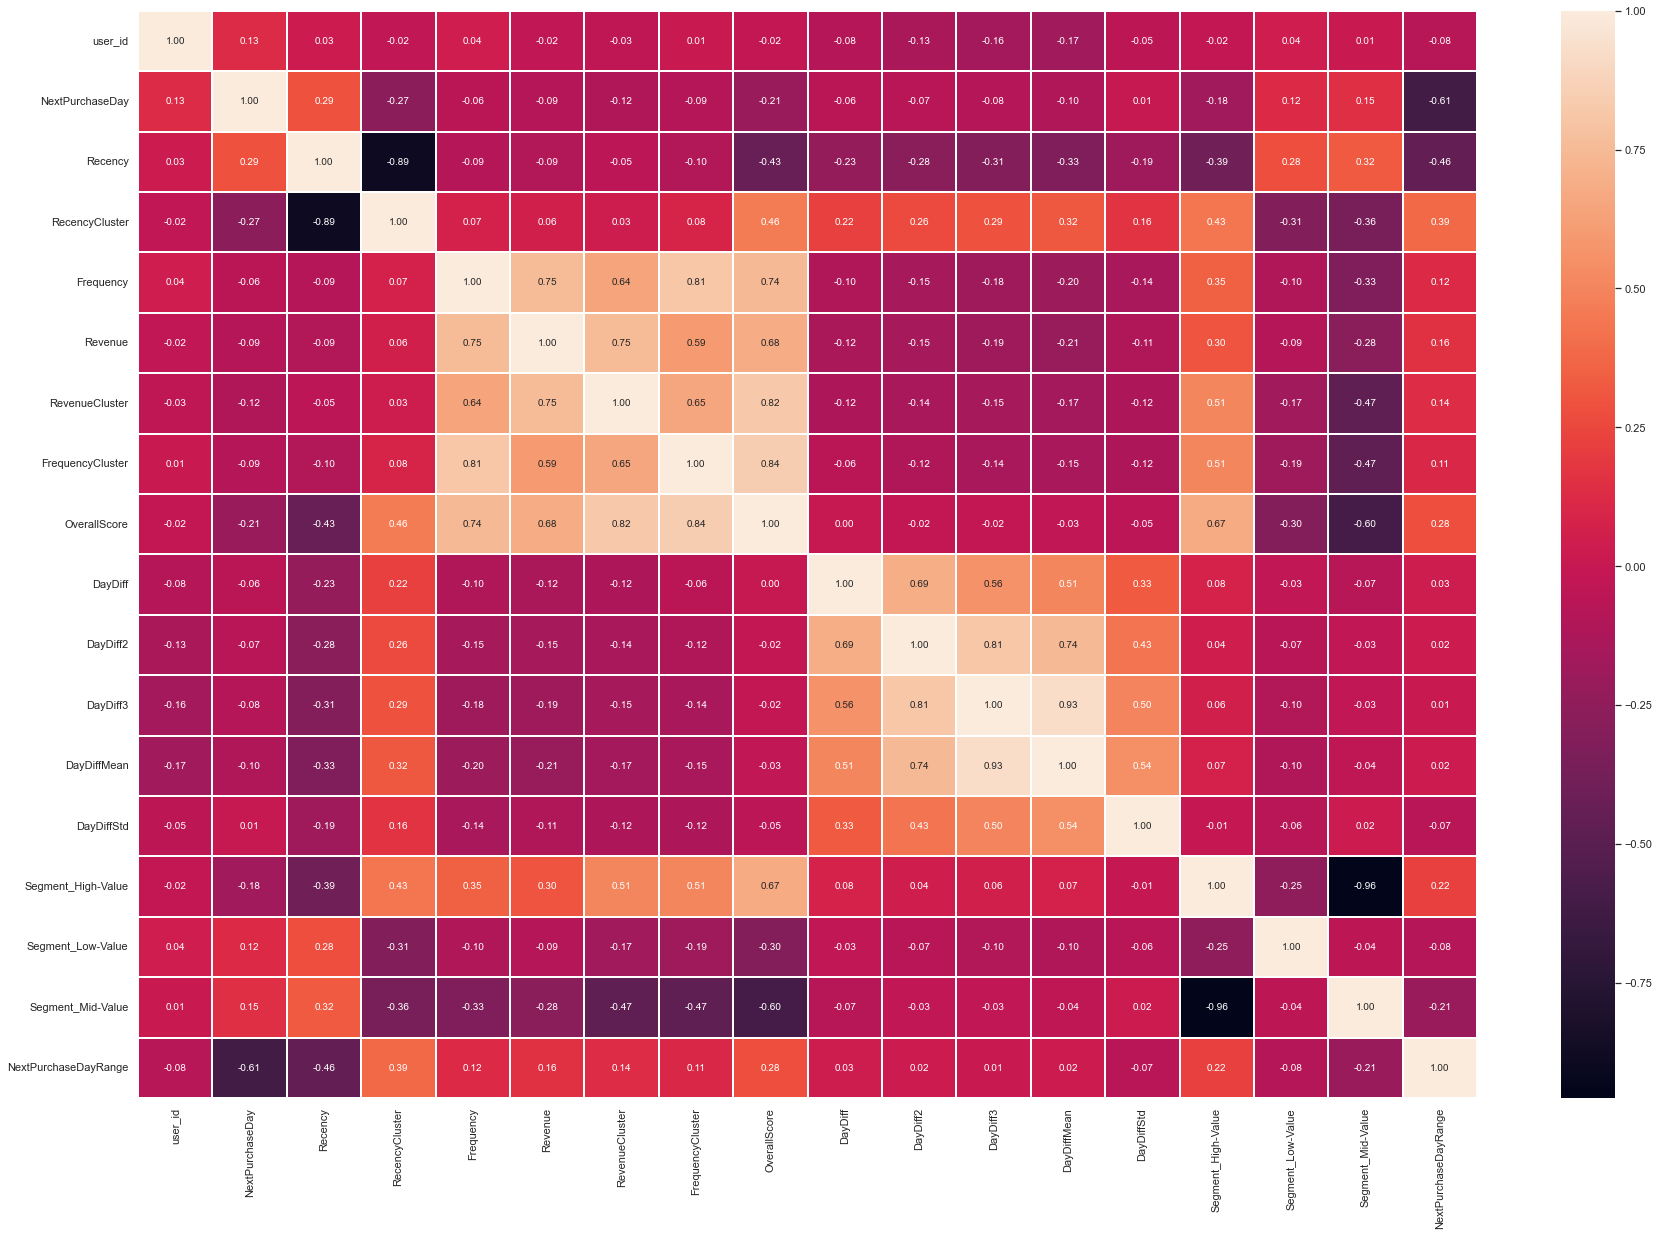

In [406]:
#correlation between features and labels
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [407]:
tx_user.head()

user_id  NextPurchaseDay  Recency  RecencyCluster  Frequency  Revenue  \
0  521821140             66.0       30               2         20    53.15   
1  508843109             50.0       30               2         23    62.93   
2  549634945            999.0       29               2         15    58.26   
3  258836295            999.0       24               2         19    60.67   
4  555434565            999.0       38               2         18    59.10   

   RevenueCluster  FrequencyCluster  OverallScore    Segment  DayDiff  \
0               0                 1             3  Mid-Value     28.0   
1               0                 1             3  Mid-Value      1.0   
2               0                 1             3  Mid-Value     25.0   
3               0                 1             3  Mid-Value     10.0   
4               0                 1             3  Mid-Value     19.0   

   DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0      33.0      46.0    15.333333   11.676187  
1      29.0      51.0    17.000000   14.177447  
2      33.0      56.0    18.666667    9.291573  
3      11.0      15.0     4.250000    4.031129  
4      20.0      21.0     7.000000   10.392305

In [408]:
tx_class1=tx_class.drop(['user_id', 'RecencyCluster', "FrequencyCluster", "RevenueCluster", 'OverallScore', 'DayDiff','DayDiff2','DayDiff3', 'DayDiffStd'], axis=1)

In [409]:
tx_class1.head()

NextPurchaseDay  Recency  Frequency  Revenue  DayDiffMean  \
0             66.0       30         20    53.15    15.333333   
1             50.0       30         23    62.93    17.000000   
2            999.0       29         15    58.26    18.666667   
3            999.0       24         19    60.67     4.250000   
4            999.0       38         18    59.10     7.000000   

   Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  \
0                   0                  0                  1   
1                   0                  0                  1   
2                   0                  0                  1   
3                   0                  0                  1   
4                   0                  0                  1   

   NextPurchaseDayRange  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

# Preparation for the dataset

In [410]:
deep_df = tx_class1.copy(deep = True)

In [411]:
tx_class1.describe().loc[['min','max', 'mean','50%'],:]

NextPurchaseDay    Recency   Frequency      Revenue  DayDiffMean  \
min           2.00000   0.000000    4.000000     9.670000     1.333333   
max         999.00000  79.000000  398.000000  2497.860000    30.333333   
mean        335.90995  18.576987   52.013897   245.719255    14.748442   
50%          42.00000  15.000000   44.000000   199.010000    14.600000   

      Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  \
min             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   
mean            0.851584           0.010561           0.137854   
50%             1.000000           0.000000           0.000000   

      NextPurchaseDayRange  
min               0.000000  
max               2.000000  
mean              0.647026  
50%               0.000000

## Machine Learning: Predictive Model

In [412]:
feat = tx_class1.drop(columns=['NextPurchaseDay','NextPurchaseDayRange' ],axis=1)
label = tx_class1["NextPurchaseDayRange"]

In [413]:
from sklearn.utils import all_estimators
import warnings
warnings.filterwarnings("ignore")

In [414]:
estimators = all_estimators(type_filter='classifier')

estimator_list = []
for number, estimator in estimators:
    print(number, estimator)
    try:
        clf = estimator()
        estimator_list.append(clf)
    except Exception as e:
        print('\nUnable to import   ------------------>', estimator,"\n")
        print(e)


AdaBoostClassifier <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
BaggingClassifier <class 'sklearn.ensemble._bagging.BaggingClassifier'>
BernoulliNB <class 'sklearn.naive_bayes.BernoulliNB'>
CalibratedClassifierCV <class 'sklearn.calibration.CalibratedClassifierCV'>
CategoricalNB <class 'sklearn.naive_bayes.CategoricalNB'>
ClassifierChain <class 'sklearn.multioutput.ClassifierChain'>

Unable to import   ------------------> <class 'sklearn.multioutput.ClassifierChain'> 

__init__() missing 1 required positional argument: 'base_estimator'
ComplementNB <class 'sklearn.naive_bayes.ComplementNB'>
DecisionTreeClassifier <class 'sklearn.tree._classes.DecisionTreeClassifier'>
DummyClassifier <class 'sklearn.dummy.DummyClassifier'>
ExtraTreeClassifier <class 'sklearn.tree._classes.ExtraTreeClassifier'>
ExtraTreesClassifier <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
GaussianNB <class 'sklearn.naive_bayes.GaussianNB'>
GaussianProcessClassifier <class 'sklearn.gaussia

In [415]:
estimator_list

[AdaBoostClassifier(),
 BaggingClassifier(),
 BernoulliNB(),
 CalibratedClassifierCV(),
 CategoricalNB(),
 ComplementNB(),
 DecisionTreeClassifier(),
 DummyClassifier(),
 ExtraTreeClassifier(),
 ExtraTreesClassifier(),
 GaussianNB(),
 GaussianProcessClassifier(),
 GradientBoostingClassifier(),
 HistGradientBoostingClassifier(),
 KNeighborsClassifier(),
 LabelPropagation(),
 LabelSpreading(),
 LinearDiscriminantAnalysis(),
 LinearSVC(),
 LogisticRegression(),
 LogisticRegressionCV(),
 MLPClassifier(),
 MultinomialNB(),
 NearestCentroid(),
 NuSVC(),
 PassiveAggressiveClassifier(),
 Perceptron(),
 QuadraticDiscriminantAnalysis(),
 RadiusNeighborsClassifier(),
 RandomForestClassifier(),
 RidgeClassifier(),
 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
 SGDClassifier(),
 SVC()]

In [416]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier






from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import  ComplementNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from sklearn import datasets
import sklearn
import time


from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import randint as sp_randFloat

In [417]:
ml_list={"ExtraTreeClassifier":ExtraTreeClassifier(),
"DecisionTreeClassifier":DecisionTreeClassifier(),
"ComplementNB":ComplementNB(),
"DummyClassifier":DummyClassifier(),         
"KNeighborsClassifier":KNeighborsClassifier(),
"OutputCodeClassifier":OutputCodeClassifier(estimator=DecisionTreeClassifier()),
"OneVsOneClassifier":OneVsOneClassifier(estimator=DecisionTreeClassifier()),
"OneVsRestClassifier":OneVsRestClassifier(estimator=DecisionTreeClassifier()),
"GradientBoostingClassifier":GradientBoostingClassifier(),
"RandomForestClassifier":RandomForestClassifier(),
"BernoulliNB":BernoulliNB(),
"CalibratedClassifierCV":CalibratedClassifierCV(),
"GaussianNB":GaussianNB(),
"LabelPropagation":LabelPropagation(),
"LabelSpreading":LabelSpreading(),
"LinearDiscriminantAnalysis":LinearDiscriminantAnalysis(),
"LinearSVC":LinearSVC(),
"LogisticRegression":LogisticRegression(),
"LogisticRegressionCV":LogisticRegressionCV(),
"MultinomialNB  ":MultinomialNB  (),
"NearestCentroid":NearestCentroid(),
"NuSVC":NuSVC(),
"Perceptron":Perceptron(),
"QuadraticDiscriminantAnalysis":QuadraticDiscriminantAnalysis(),
"SVC":SVC(),
"HistGradientBoostingClassifier":HistGradientBoostingClassifier(),
"CategoricalNB" : CategoricalNB()}


## Finding the model with best accuracy 

In [418]:
X_train, X_test, y_train, y_test = train_test_split(feat, label, test_size = 0.25, random_state = 0)

print ('%-40s %-20s %-20s %-20s %-20s' % ("Model".center(22) ,"F1 Score".center(20),"Accuracy".center(15) ,"Training Time".center(15),"Testing Time".center(15) ))
print ('%-40s %-20s %-20s %-20s %-20s' % ("|____________________|","____________________","____________________" ,"____________________","____________________" ))
#X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size = 0.25, random_state = 0)

for i in ml_list:
    try:
        clf=ml_list[i]
        second=time.time()
        clf.fit(X_train, y_train)
        train=round(time.time()-second,5)
        second=time.time()
        predict =clf.predict(X_test)
        test=round(time.time()-second,5)
        f1=round(sklearn.metrics.f1_score(y_test, predict, average='macro'),5)
        acc=round(sklearn.metrics.accuracy_score(y_test, predict),5)
        print ('%-40s %-20s %-20s %-20s %-20s' % (i,f1,acc,train,test ))
    except:        print ('%-40s %-20s %-20s' % (i,"Error","Error" ))


        Model                                  F1 Score           Accuracy          Training Time         Testing Time      
|____________________|                   ____________________ ____________________ ____________________ ____________________
ExtraTreeClassifier                      0.45693              0.51333              0.01104              0.00194             
DecisionTreeClassifier                   0.46976              0.53778              0.01213              0.00231             
ComplementNB                             0.39023              0.53111              0.004                0.00151             
DummyClassifier                          0.2381               0.55556              0.00092              0.00015             
KNeighborsClassifier                     0.41728              0.53556              0.00342              0.02248             
OutputCodeClassifier                     0.45024              0.52222              0.02945              0.00313             


In [529]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feat, label, test_size=0.2, random_state=0)

In [420]:
from sklearn.preprocessing import StandardScaler

In [530]:
#standarized the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.fit_transform(X_test)

# SVM Model

In [422]:
from sklearn.svm import SVC

In [531]:
support_vector_classifier = SVC(kernel='rbf')
support_vector_classifier.fit(X_train,y_train)
y_pred_svc = support_vector_classifier.predict(X_test)

In [532]:
from sklearn.metrics import confusion_matrix
cm_support_vector_classifier = confusion_matrix(y_test,y_pred_svc)
print(cm_support_vector_classifier,end='\n\n')

[[168  23   6]
 [ 68  26  17]
 [ 33   3  16]]



In [533]:
numerator = cm_support_vector_classifier[0][0] + cm_support_vector_classifier[1][1]
denominator = sum(cm_support_vector_classifier[0]) + sum(cm_support_vector_classifier[1])
acc_svc = (numerator/denominator) * 100
print("Accuracy : ",round(acc_svc,2),"%")

Accuracy :  62.99 %


In [534]:
from sklearn.model_selection import cross_val_score
cross_val_svc = cross_val_score(estimator = SVC(kernel = 'rbf'), X = X_train, y = y_train, cv = 10, n_jobs = -1)
print("Cross Validation Accuracy : ",round(cross_val_svc.mean() * 100 , 2),"%")

Cross Validation Accuracy :  54.41 %


# RandomForest

In [427]:
from sklearn.ensemble import RandomForestClassifier

In [428]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train)
y_pred_rfc = random_forest_classifier.predict(X_test)

In [429]:
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pylab import rcParams 
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.models import Sequential

In [430]:
cm_random_forest_classifier = confusion_matrix(y_test,y_pred_rfc)
print(cm_random_forest_classifier,end="\n\n")

[[142  39  16]
 [ 51  42  18]
 [ 21   8  23]]



In [431]:
numerator = cm_random_forest_classifier[0][0] + cm_random_forest_classifier[1][1]
denominator = sum(cm_random_forest_classifier[0]) + sum(cm_random_forest_classifier[1])
acc_rfc = (numerator/denominator) * 100
print("Accuracy : ",round(acc_rfc,2),"%")

Accuracy :  59.74 %


In [432]:
cross_val_rfc = cross_val_score(estimator=RandomForestClassifier(), X=X_train, y=y_train, cv=10, n_jobs=-1)
print("Cross Validation Accuracy : ",round(cross_val_rfc.mean() * 100 , 2),"%")

Cross Validation Accuracy :  53.23 %


## XGB

In [433]:
from xgboost import XGBClassifier

In [434]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

[18:12:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [435]:
cm_xgb_classifier = confusion_matrix(y_test,y_pred_xgb)
print(cm_xgb_classifier,end='\n\n')

[[129  50  18]
 [ 42  50  19]
 [ 16   7  29]]



In [436]:
numerator = cm_xgb_classifier[0][0] + cm_xgb_classifier[1][1]
denominator = sum(cm_xgb_classifier[0]) + sum(cm_xgb_classifier[1])
acc_xgb = (numerator/denominator) * 100
print("Accuracy : ",round(acc_xgb,2),"%")

Accuracy :  58.12 %


In [437]:
cross_val_xgb = cross_val_score(estimator=XGBClassifier(), X=X_train, y=y_train, cv=10, n_jobs=-1)
print("Cross Validation Accuracy : ",round(cross_val_xgb.mean() * 100 , 2),"%")

Cross Validation Accuracy :  51.84 %


<AxesSubplot:>

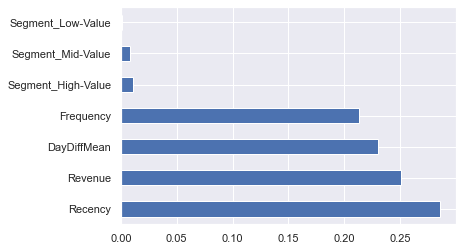

In [438]:
feat_importances = pd.Series(random_forest_classifier.feature_importances_, index=feat.columns)
feat_importances.nlargest(10).plot(kind='barh')

## Deep Learning

In [439]:
import tensorflow as tf

In [440]:
deep_feat = tx_class1.drop(columns=['NextPurchaseDay','NextPurchaseDayRange' ],axis=1)
deep_label = tx_class1["NextPurchaseDayRange"]

In [441]:
list(deep_feat.columns)

['Recency',
 'Frequency',
 'Revenue',
 'DayDiffMean',
 'Segment_High-Value',
 'Segment_Low-Value',
 'Segment_Mid-Value']

In [442]:
categorical_columns = [col for col in deep_feat.columns if len(deep_feat[col].unique())==2 or deep_feat[col].dtype=='O']

In [443]:
continuous_columns = [col for col in deep_feat.columns if len(deep_feat[col].unique())>2 and (deep_feat[col].dtype=='int64' or deep_feat[col].dtype=='float64')]

In [444]:
print("categorical columns : ", categorical_columns)
print("continuous columns : ", continuous_columns)

categorical columns :  ['Segment_High-Value', 'Segment_Low-Value', 'Segment_Mid-Value']
continuous columns :  ['Recency', 'Frequency', 'Revenue', 'DayDiffMean']


In [445]:
cols_to_scale = continuous_columns[:]

In [446]:
X_T, X_t, y_T, y_t = train_test_split(deep_feat, deep_label, test_size=0.2)

In [447]:
# scaling the listed columns
scaler = StandardScaler()
X_T.loc[:,cols_to_scale] = scaler.fit_transform(X_T.loc[:,cols_to_scale])
X_t.loc[:,cols_to_scale] = scaler.fit_transform(X_t.loc[:,cols_to_scale])

In [448]:
categorical_object_feat_cols = [tf.feature_column.embedding_column(                                   
tf.feature_column.categorical_column_with_hash_bucket(key=col,hash_bucket_size=1000), dimension = len(deep_df[col].unique()))
 
for col in categorical_columns if deep_df[col].dtype=='O']

In [449]:
categorical_integer_feat_cols = [tf.feature_column.embedding_column(                 
tf.feature_column.categorical_column_with_identity(key=col,num_buckets=2),dimension = len(deep_df[col].unique()))
 
for col in categorical_columns if deep_df[col].dtype=='int64']

In [450]:
continuous_feat_cols = [tf.feature_column.numeric_column(key=col) for col in continuous_columns if col != "Age"]

In [451]:
feat_cols = categorical_object_feat_cols + \
            categorical_integer_feat_cols + \
            continuous_feat_cols

In [452]:
input_fun =tf.compat.v1.estimator.inputs.pandas_input_fn(X_T,y_T,batch_size=50,num_epochs=1000,shuffle=True)
pred_input_fun =tf.compat.v1.estimator.inputs.pandas_input_fn(X_t,batch_size=50,shuffle=False)

In [453]:
DNN_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10], feature_columns=feat_cols, n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/yg/nms6zx692cb6jbvjdp63flgh0000gp/T/tmpl707zgdx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


2021-10-09 18:14:17.374950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [454]:
DNN_model.train(input_fn=input_fun, steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


2021-10-09 18:14:29.418539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/yg/nms6zx692cb6jbvjdp63flgh0000gp/T/tmpl707zgdx/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1215261, step = 0
INFO:tensorflow:global_step/sec: 176.995
INFO:tensorflow:loss = 1.1269996, step = 100 (0.570 sec)
INFO:tensorflow:global_step/sec: 304.776
INFO:tensorflow:loss = 1.0290645, step = 200 (0.327 sec)
INFO:tensorflow:global_step/sec: 243.974
INFO:tensorflow:loss = 1.088084, step = 300 (0.410 sec)
INFO:tensorflow:global_step/sec: 212.023
INFO:tensorflow:loss = 1.0396222, step = 400 (0.474 sec)
INFO:tensorflow:global_step/sec: 259.756
INFO:tensorflow:loss = 1.0848061, step = 500 (0.382 sec)
INFO:tensorflow:global_step/sec: 2

In [455]:
predictions = DNN_model.predict(pred_input_fun)

In [456]:
res_pred = list(predictions)
res_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/yg/nms6zx692cb6jbvjdp63flgh0000gp/T/tmpl707zgdx/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([ 0.08424925, -0.2146963 , -0.5358005 ], dtype=float32),
 'probabilities': array([0.43868935, 0.32533193, 0.23597875], dtype=float32),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1, 2], dtype=int32),
 'all_classes': array([b'0', b'1', b'2'], dtype=object)}

In [457]:
y_pred = []
for i in range(len(res_pred)):
    y_pred.append(res_pred[i]["class_ids"][0])

In [458]:
from sklearn.metrics import classification_report
rep = classification_report(y_t,y_pred)

In [459]:
print(rep)

              precision    recall  f1-score   support

           0       0.53      0.97      0.69       188
           1       0.35      0.05      0.09       113
           2       0.00      0.00      0.00        59

    accuracy                           0.53       360
   macro avg       0.30      0.34      0.26       360
weighted avg       0.39      0.53      0.39       360



# Linear Regression with continuous variables(NextPurchaseDay)

In [460]:
feat4 = tx_class1.drop(columns=['NextPurchaseDay','NextPurchaseDayRange' ],axis=1)
label4 = tx_class1["NextPurchaseDay"]

In [461]:
data=tx_class1.drop(columns=['NextPurchaseDayRange' ],axis=1)

In [462]:
final_data=data.values

In [463]:

X_train, X_test, y_train, y_test = train_test_split(feat4, label4, test_size=0.2, random_state=0)

In [464]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [465]:
coeff_df = pd.DataFrame(regressor.coef_, feat4.columns, columns=['Coefficient'])
coeff_df

Coefficient
Recency                7.928299
Frequency              0.538919
Revenue               -0.195219
DayDiffMean           -1.543889
Segment_High-Value   -65.672507
Segment_Low-Value     89.224217
Segment_Mid-Value    -23.551711

In [466]:
y_pred = regressor.predict(X_test)

In [469]:
df12= pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df12

Actual   Predicted
597    999.0  318.170351
831     27.0  292.721584
1174    29.0  296.980152
467     12.0  222.269638
1721     5.0 -126.666261
...      ...         ...
1540    37.0  192.288485
1671   999.0  211.542154
1299    41.0  284.209502
1482    23.0  261.063596
1692    32.0  219.613117

[360 rows x 2 columns]

In [467]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 383.69548988061274
Mean Squared Error: 184794.65481125202
Root Mean Squared Error: 429.8774881419729


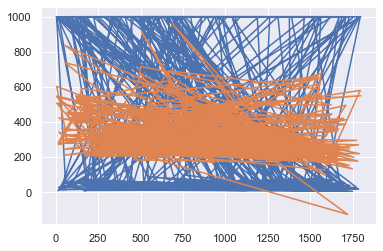

In [470]:
plt.plot(df12[['Actual', "Predicted"]])